In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy import stats
from skimage.morphology import erosion, dilation, disk
from skimage.measure import find_contours

plt.rcParams["figure.figsize"] = (10,10)

from ipyfilechooser import FileChooser

#Выбор входного изображения
#Путь не должен содержать кириллицу!
fc = FileChooser()
display(fc)

FileChooser(path='C:\Users\Vladislav\Documents\Processing and recognition of images\Lab 2', filename='', title…

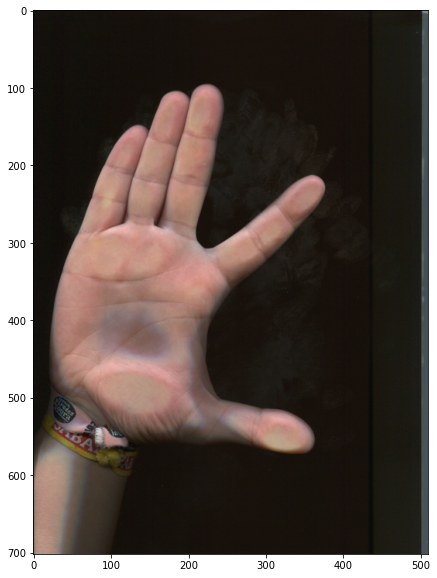

In [2]:
#Считывание изображения
photo = cv2.imread(fc.selected, cv2.IMREAD_COLOR)
photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
plt.imshow(photo)

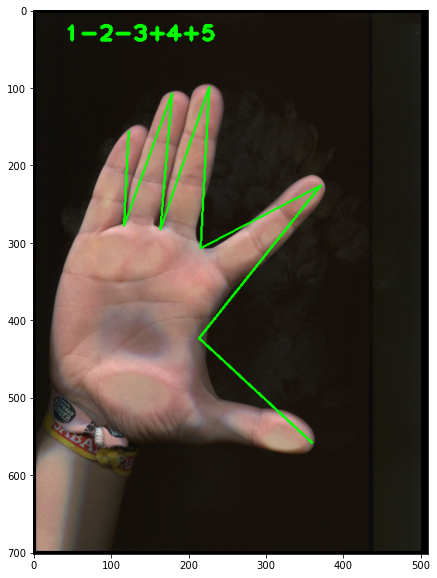

In [3]:
#Вычисление градусной меры угла ABC
def calc_angle(a,b,c):
    ba = a-b
    bc = c-b
    cosine_angle = np.dot(ba,bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle) 
    pAngle = np.degrees(angle)
    return pAngle

#Расстояние между точками A и B на плоскости
def distance(a,b):
    x = np.asarray(a)
    y = np.asarray(b)
    return np.linalg.norm(x-y)

#Функция для получения значения ключа из словаря по значению
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

#Обработка краёв кадра для избавления от артефактов, а также для корректного выделения контура ладони
photo[:,-9:] = (0,0,0)
photo[:,:4] = (0,0,0)
photo[:4,:] = (0,0,0)
photo[-4:,:] = (0,0,0)

#Отсев неяркий пикселей
sub = photo.sum(axis=2) > 200
wo_wrist = photo * sub[:, :, None]

#Попытка убрать складки кожи размытием
wo_wrist = cv2.GaussianBlur(wo_wrist, (3,3), 0)    
    
gray = cv2.cvtColor(wo_wrist, cv2.COLOR_RGB2GRAY)

#Оператор Лапласа для поиска границ
grad = cv2.Laplacian(gray, cv2.CV_16S, ksize=3)
grad = cv2.convertScaleAbs(grad)

#Бинаризация
tmp = grad.copy()
r, test = cv2.threshold(tmp, 50, 1, cv2.THRESH_BINARY)
tmp = dilation(test, disk(2))
tmp = erosion(tmp, disk(1))

#Поиск контуров после бинаризации
contours, hierarchy = cv2.findContours(np.uint8(tmp), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
big_contours = []
for i in range(len(contours)):
    #Рассматриваем только большие контуры
    if cv2.contourArea(contours[i]) > 500:
        big_contours.append(contours[i])
contours = big_contours
contours.sort(key = lambda x: cv2.contourArea(x))
if len(contours) == 1:
    contour = contours[0]
#Иногда в результате поиска контура получается два контура из-за широкой границы после бинаризации
#Меньшая -- лучше
elif cv2.contourArea(contours[-1]) / cv2.contourArea(contours[-2]) > 1.5:
    contour = contours[-1]
else:
    contour = contours[-2]

res = photo.copy()
#Построение выпуклой оболочки
hull = cv2.convexHull(contour, returnPoints=False)
defects = cv2.convexityDefects(contour, hull)
dots = []
fingers = []
for i in range(defects.shape[0]):
    s, e, f, d = defects[i][0]
    start = tuple(contour[s][0])
    end = tuple(contour[e][0])
    far = tuple(contour[f][0])
    #Рассматриваем достаточно далёкие точки из дефектов,
    #образующие при этом угол с началом и концом не превышающий 111 градусов
    if d > 11000 and calc_angle(np.asarray(start), np.asarray(far), np.asarray(end)) < 111:
        dots.append(far)
        fingers.append([start, end])

good_dots = []
good_fingers = []
#Иногда подходящих точек больше, чем 4 (обычно лишние возникают из-за запястья)
if len(dots) > 4:
    #В этом случае производим кластеризацию и больший класс считаем нужным
    kmeans = KMeans(n_clusters=2, random_state=0).fit(dots)
    good_class = stats.mode(kmeans.labels_)[0][0]
    for i in range(len(dots)):
        if kmeans.labels_[i] == good_class:
            good_dots.append(dots[i])
            good_fingers.append(fingers[i])    
else:
    good_dots = dots.copy()
    good_fingers = fingers.copy()

#Определение усреднённой координаты для точек между пальцами
x_sum = 0
y_sum = 0
mean_dots = [x_sum,y_sum]
for i in range(len(good_dots)):
    x_sum += good_dots[i][0]
    y_sum += good_dots[i][1]
mean_dots[0] = round(x_sum/len(good_dots))
mean_dots[1] = round(y_sum/len(good_dots))
mean_dots = tuple(mean_dots)

#Поиск самой дальней точки от усреднённой
max_distance = 0
md_index = 0
for i in range(len(good_dots)):
    cur_dist = distance(good_dots[i], mean_dots)
    if cur_dist > max_distance:
        max_distance = cur_dist
        md_index = i

#Определение точки у основания большого пальца и сортировка остальных точек
right_good_dots = good_dots.copy()
thumb = right_good_dots.pop(md_index)
right_good_dots.sort(key = lambda x: distance(x, thumb))
right_good_dots.insert(0,thumb)

indices = [i for i in range(len(good_dots))]
good_dots_dict = dict(zip(indices,good_dots))

#Сортировка точек, соответствующих вершинам пальцев
fingers_indicies = [get_key(good_dots_dict, right_good_dots[i]) for i in range(len(right_good_dots))]

right_good_fingers = []
good_fingers_dict = dict(zip(indices,good_fingers))
for i in range(len(fingers_indicies)):
    right_good_fingers.append(good_fingers_dict[fingers_indicies[i]][::-1])

#Усреднение концевых точек для построения линии
for i in range(1,len(good_fingers)):
    right_good_fingers[i][0] = ((right_good_fingers[i][0][0] + right_good_fingers[i-1][1][0]) // 2, 
                                (right_good_fingers[i][0][1] + right_good_fingers[i-1][1][1]) // 2)

#Построение линии
line = []
for i in range(len(good_dots)):
    line.append(right_good_fingers[i][0])
    line.append(right_good_dots[i])
line.append(right_good_fingers[i][1])
              
for i in range(len(line)-1):
    cv2.line(res, line[i], line[i+1], (0, 255, 0), thickness=2)

#Определение кода позы ладони
answer = '1'
if len(good_dots) != 4:
    answer = 'Error'
else:
    for i in range(4):
        if calc_angle(np.asarray(line[i*2]),np.asarray(line[i*2 + 1]),np.asarray(line[(i+1)*2])) > 20:
            answer += "-"+str(i+2)
        else:
            answer += "+"+str(i+2)
    
cv2.putText(res,answer,(40,40),1,2,(0,255,0),3)
plt.imshow(res)

In [4]:
#Вывод координат в заданном формате
coords = "!"+fc.selected.split("\\")[-1] + ","
for i in range(len(right_good_fingers)):
    coords += "T" + " " + str(right_good_fingers[i][0][0]) + " " + str(right_good_fingers[i][0][1]) + ","
coords +=  "T" + " " + str(right_good_fingers[i][1][0]) + " " + str(right_good_fingers[i][1][1]) + ","
for i in range(len(right_good_dots)):
    coords += "V" + " " + str(right_good_dots[i][0]) + " " + str(right_good_dots[i][1]) + ","
coords += "?"
print(coords)

!174.tif,T 360 558,T 371 226,T 227 99,T 179 107,T 123 156,V 214 423,V 216 307,V 164 283,V 117 278,?


In [5]:
#Сохранение кода и координат в файл
f = open('Results.txt','w') 
f.write(answer+'\n'+coords) 
f.close()  